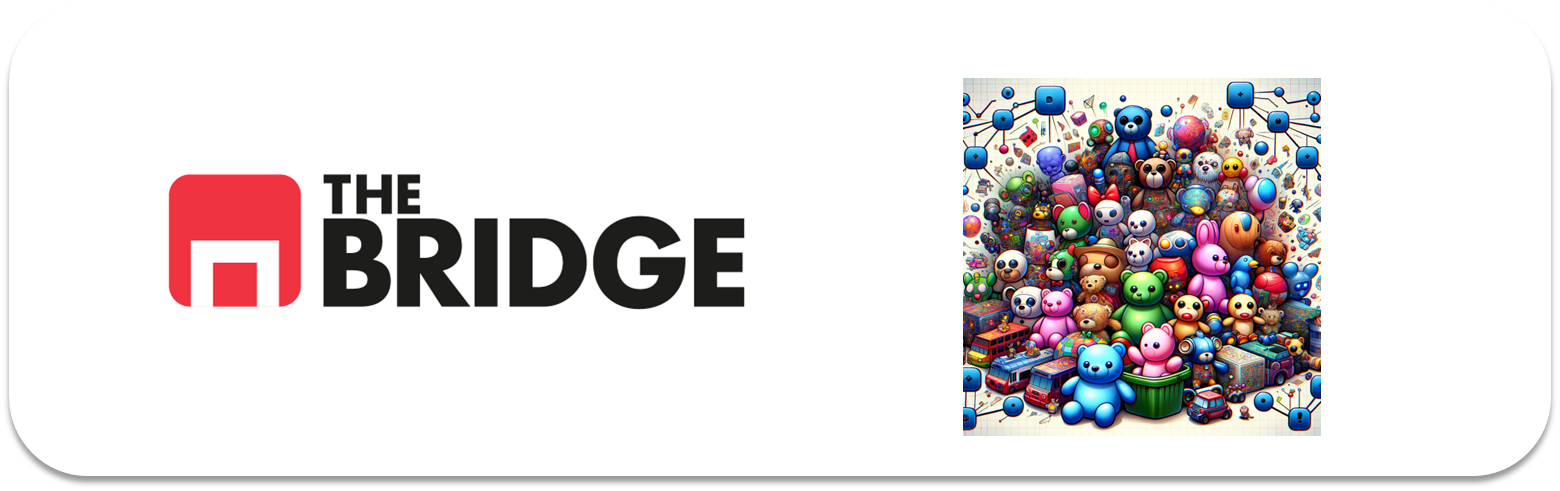

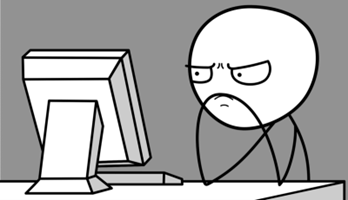

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

import scipy.cluster.hierarchy as shc
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, AgglomerativeClustering

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [3]:
path1 = "./data/empowering_drinks.csv"
data = pd.read_csv(path1, sep = "|")
data

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276
...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783
149,0.332758,-0.389355,-1.344582,0.280575,2.224236
150,0.209232,0.012732,-1.354622,0.296498,1.834923
151,1.395086,1.365208,-1.274305,-0.595160,1.791666


In [4]:
data.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


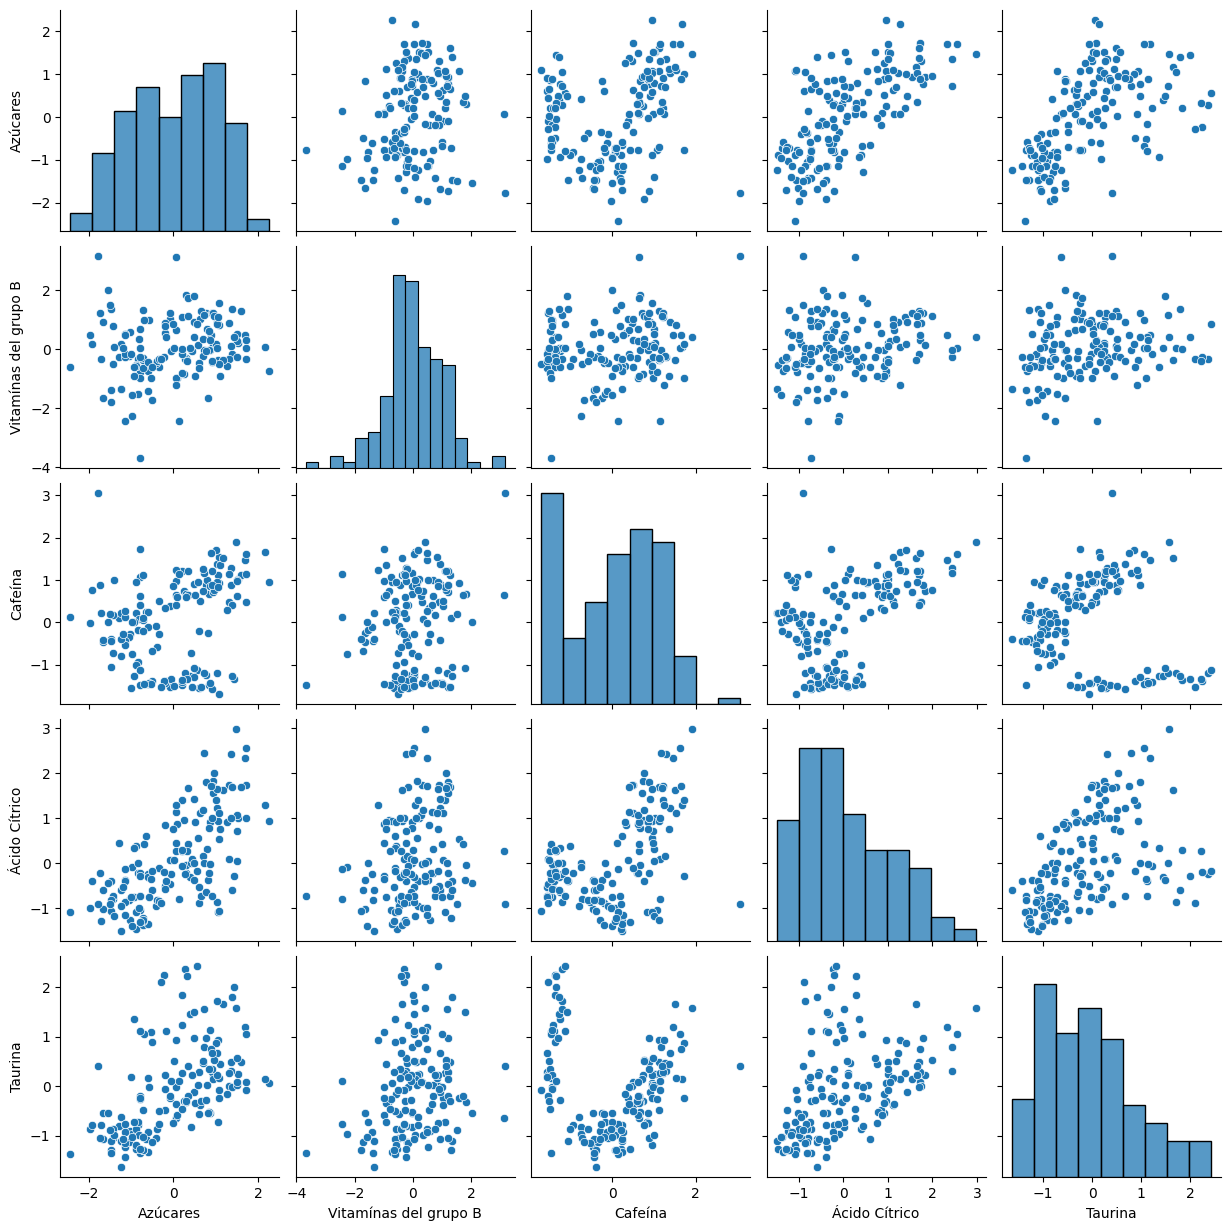

In [6]:
sns.pairplot(data);

*En el análisis bivariante, podemos intuir alguna que otra agrupación. Sin embargo, la feature Vitaminas del grupo B parece no aportar demasiado, puesto que no se puede ver ningún tipo de clusterización con ella. Por ello, vamos a quedarnos con todas las features, menos esta.*

In [10]:
features = data.columns.to_list()
features.remove('Vitamínas del grupo B')
features

['Azúcares', 'Cafeína', 'Ácido Cítrico', 'Taurina']

In [11]:
data[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Azúcares       153 non-null    float64
 1   Cafeína        153 non-null    float64
 2   Ácido Cítrico  153 non-null    float64
 3   Taurina        153 non-null    float64
dtypes: float64(4)
memory usage: 4.9 KB


*Todas las distribuciones tienden a la normal, así que vamos a escalar todas las features elegidas y a preparar nuestros modelos.*

In [16]:
scaler = StandardScaler()

data[features] = scaler.fit_transform(data[features])
data[features].describe()

,Azúcares,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,1.530000e+02
mean,0.000000,0.000000,0.000000,-5.805088e-18
std,1.003284,1.003284,1.003284,1.003284e+00
min,-2.398720,-1.674210,-1.563600,-1.707432e+00
25%,-0.816631,-1.045232,-0.813485,-8.110253e-01
50%,0.040837,0.164343,-0.243777,-1.189805e-01
75%,0.837920,0.822351,0.832337,5.777089e-01
max,2.190546,2.912496,2.873790,2.658488e+00


*A continuación vamos a preparar ambos modelos:*

*Para elegir los hiperparámetros de DBSCAN podemos tener en cuenta que menos del 10% de los etiquetados sean anomalías y como parámetro del min_samples, utilizar el doble de features a utilizar.*

In [42]:
for i in np.arange(0.001, 2, 0.005):
    db = DBSCAN(eps = i, min_samples = (len(data[features].columns)) * 2)
    pred = db.fit_predict(data[features])
    anomaly = sum(pred == -1) / len(pred)
    if anomaly < 0.1:
        break

print(db, "\n", anomaly)

DBSCAN(eps=0.906, min_samples=8) 
 0.09803921568627451


In [47]:
print(np.unique(db.labels_))
db.labels_

[-1  0  1]


array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1, -1,  0,  0,  0, -1,  0,  0, -1, -1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1],
      dtype=int64)

*Para el jerárquico, vamos a utilizar un dendrograma para ver qué k podemos escoger.*

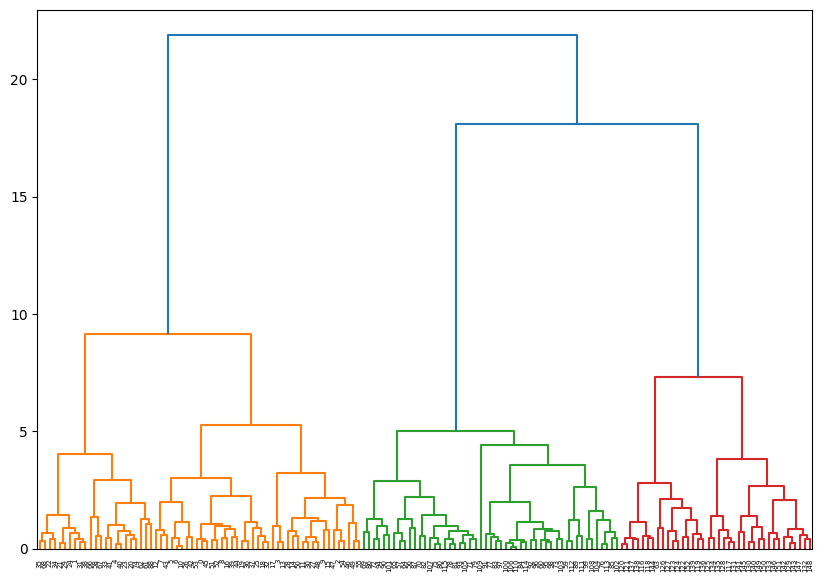

In [45]:
plt.figure(figsize=(10, 7))

selected_data = data[features]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z = clusters)
plt.axhline(y = 300, color = 'r', linestyle = '-')
plt.show()

*Basándonos en el dendrograma, utilizaremos una k = 3 para entrenar nuestro modelo jerárquico.*

In [46]:
clustering_model = AgglomerativeClustering(n_clusters = 3, linkage= "ward", metric = "euclidean")

clustering_model.fit(data[features])
clustering_model.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 1, 2, 2,
       0, 0, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [53]:
data_viz_dbs = data[features].copy()
data_viz_dbs["Label"] = db.labels_

data_viz_jer = data[features].copy()
data_viz_jer["Label"] = clustering_model.labels_

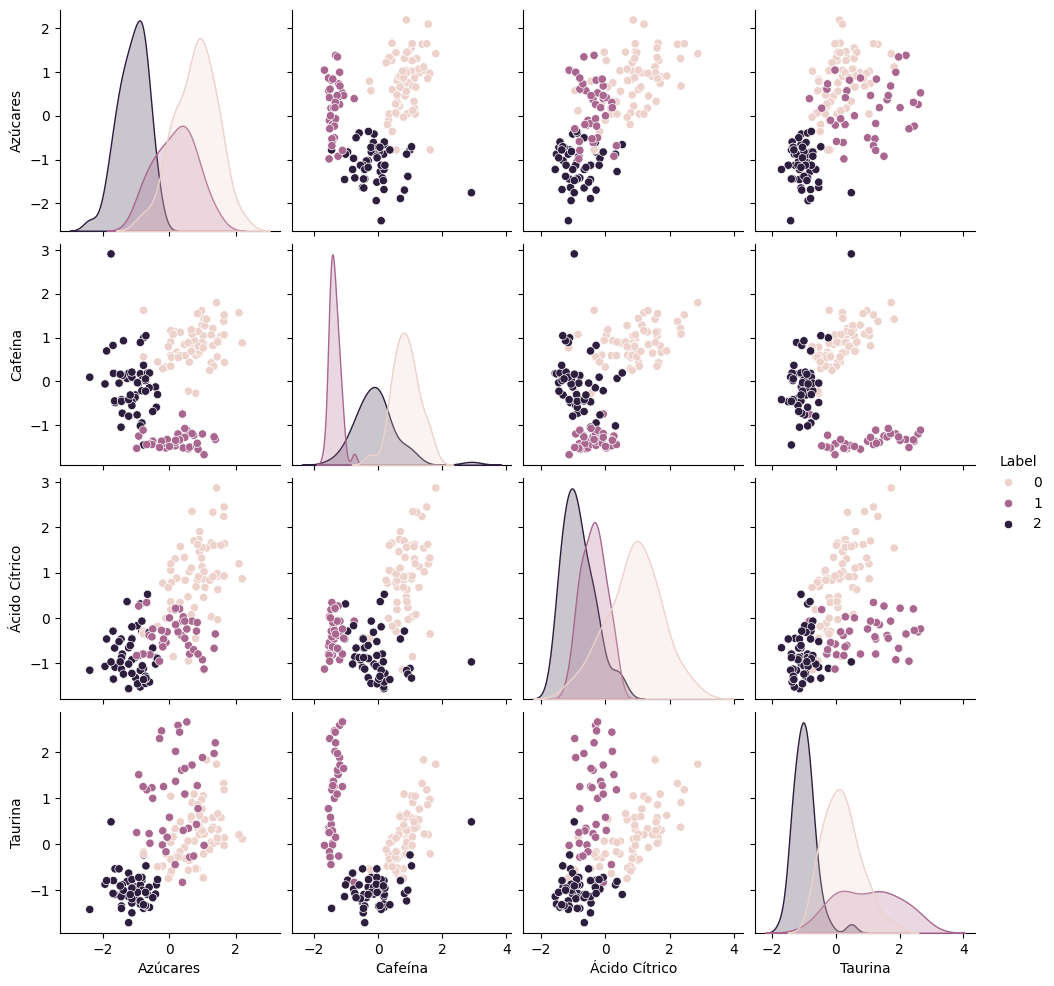

In [52]:
sns.pairplot(data_viz_jer, hue = "Label");

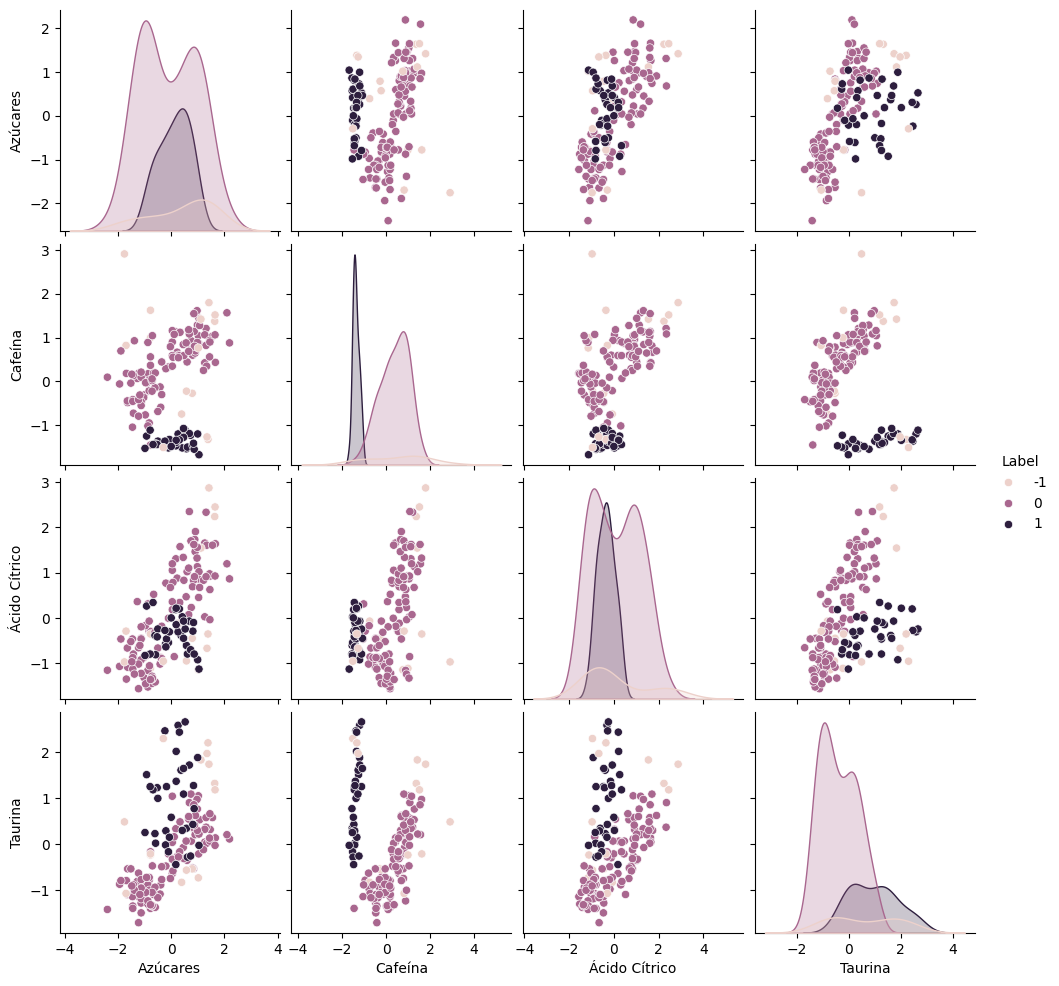

In [54]:
sns.pairplot(data_viz_dbs, hue = "Label");

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [57]:
path2 = "./data/new_experiments.csv"

new_data = pd.read_csv(path2, sep = "|")
new_data

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [58]:
clustering_model.fit_predict(new_data[features])
clustering_model.labels_

array([0, 0, 1, 1, 1, 2], dtype=int64)

In [60]:
new_data_viz = new_data[features].copy()
new_data_viz["Label"] = clustering_model.labels_

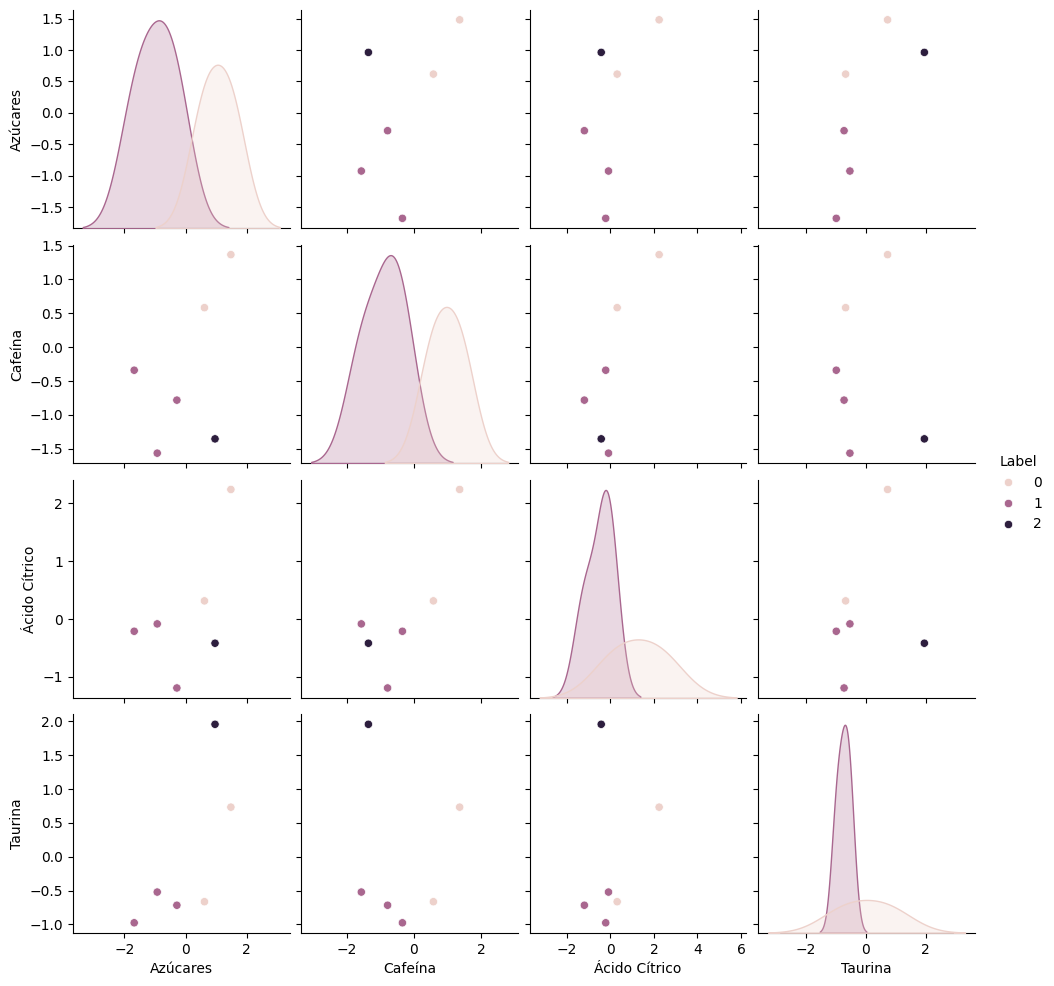

In [61]:
sns.pairplot(new_data_viz, hue = "Label");

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.